In [1]:

import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

#E(2)-steerable CNNs - librar"y:
from e2cnn import gspaces    
from e2cnn import nn as G_CNN   
import e2cnn

#Plotting in 2d/3d:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse,Rectangle, Circle
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

#Tools:
import datetime
import sys
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.append('../../')
#Own files:
import Kernel_and_GP_tools as GP
import My_Tools
import EquivDeepSets 
import Equivariance_Tester 
import Training
from Cov_Converter import cov_converter
import Decoder_Models as models
import Architectures
import CNP.CNP_Model as CNP_Model
import EquivCNP
import Tasks.ERA5.ERA5_Dataset as Dataset

#HYPERPARAMETERS and set seed:
torch.set_default_dtype(torch.float)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


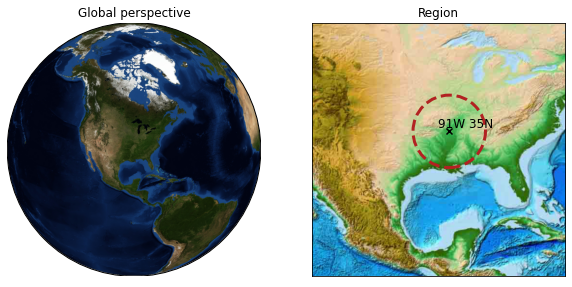

In [2]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10, 5))
m1 = Basemap(projection='ortho', resolution=None, lat_0=35, lon_0=-90,ax=ax[0])
m1.bluemarble(scale=0.5)
ax[0].set_title('Global perspective')

m_2 = Basemap(llcrnrlon=-110,llcrnrlat=15,urcrnrlon=-75,urcrnrlat=50, resolution=None,ax=ax[1])
m_2.etopo()
circle=Circle((-91.,35), 5, fill=False,linewidth=3,edgecolor='firebrick',linestyle='--')
ax[1].scatter([-91],[35],color='black', marker='x')
ax[1].annotate("91W 35N", xy=(-91,35),xytext=(-92.5,35.5),fontsize='large',color='black')
ax[1].add_patch(circle)

ax[1].set_title('Region')
plt.savefig("ERA5_US_region.pdf",pad_inches=0.,bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


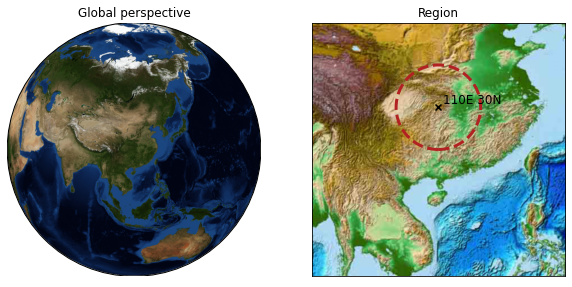

In [3]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10, 5))
m1 = Basemap(projection='ortho', resolution=None, lat_0=30, lon_0=110,ax=ax[0])
m1.bluemarble(scale=0.5)
ax[0].set_title('Global perspective')

m_2 = Basemap(llcrnrlon=95,llcrnrlat=10,urcrnrlon=125,urcrnrlat=40, resolution=None,ax=ax[1])
m_2.etopo()
circle=Circle((110.,30), 5, fill=False,linewidth=3,edgecolor='firebrick',linestyle='--')
ax[1].scatter([110],[30],color='black', marker='x')
ax[1].annotate("110E 30N", xy=(110,30),xytext=(110.5,30.5),fontsize='large',color='black')
ax[1].add_patch(circle)

ax[1].set_title('Region')
plt.savefig("ERA5_China_region.pdf",pad_inches=0.,bbox_inches='tight')

In [4]:
data='small'
if data=='small':
        PATH_TO_TEST_FILE="../../Tasks/ERA5/ERA5_US/Data/Test_Small_ERA5_US.nc"
elif data=='big':
        PATH_TO_TEST_FILE="../../Tasks/ERA5/ERA5_US/Data/Test_Big_ERA5_US.nc"
else:
    sys.exit("Unknown data set.")


In [5]:
#Set minimum and maximum number of context points:
MIN_N_CONT=5
MAX_N_CONT=20
#Load the data set:
test_dataset=Dataset.ERA5Dataset(PATH_TO_TEST_FILE,MIN_N_CONT,MAX_N_CONT,place='US',normalize=True,circular=True)


_______________________
Loaded weather data: 
-----
Shape:  (2160, 41, 41, 4)
Variables:  ['sp_in_kPa', 't_in_Cels', 'wind_10m_east', 'wind_10m_north']
West-East Longtitude:  -96.0 -86.0
South-North Latitude:  30.0 40.0
Grid points per map:  1681
________________________



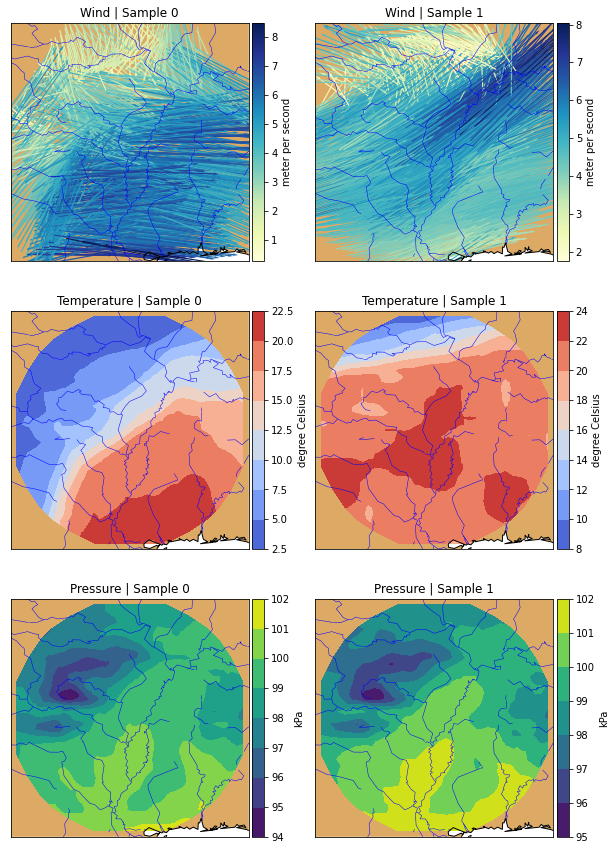

In [6]:
fig, ax=plt.subplots(nrows=3,ncols=2,figsize=(10,15))
scale=6.
width=2
for i in range(2):
    X,Y=test_dataset.get_rand_map()
    for j in range(3):
        m = Basemap(llcrnrlon=-96.,llcrnrlat=30.,urcrnrlon=-86.,urcrnrlat=40., resolution='l',ax=ax[j][i])
        m.fillcontinents(color='#ddaa66',zorder=0)
        m.drawrivers(color='#0000ff')
        m.drawcoastlines()
            
    #width=ax[0][i].get_xlim()[1]-ax[0][i].get_xlim()[0]
    #ax[0][i].set_title("Wind")
    wind_speed=Y[:,[2,3]].norm(dim=1)
    norm = matplotlib.colors.Normalize()
    norm.autoscale(wind_speed)
    cm=plt.cm.YlGnBu

    quiver=ax[0][i].quiver(X[:,0],X[:,1],Y[:,2],Y[:,3],wind_speed,pivot='mid',scale_units='width',scale=width*scale,headlength=4., headwidth = 2.,width=0.005,cmap=cm)
    ax[0][i].set_title("Wind | Sample "+str(i))
    divider = make_axes_locatable(ax[0][i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb=fig.colorbar(quiver, cax=cax)
    cb.set_label(label="meter per second",x=0.)

    tricontour=ax[1][i].tricontourf(X[:,0],X[:,1],Y[:,1],cmap=plt.cm.coolwarm)
    divider1 = make_axes_locatable(ax[1][i])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cb1=fig.colorbar(tricontour, cax=cax1)
    cb1.set_label(label="degree Celsius",x=0.)

    ax[1][i].set_title("Temperature | Sample "+str(i))
    tricontour2=ax[2][i].tricontourf(X[:,0],X[:,1],Y[:,0])
    divider2 = make_axes_locatable(ax[2][i])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    cb2=fig.colorbar(tricontour2, cax=cax2)
    cb2.set_label(label="kPa",x=-0.5)
    ax[2][i].set_title("Pressure | Sample "+str(i))

plt.savefig("ERA5_US_Examples_2.pdf",pad_inches=0.,bbox_inches='tight')




Text(0.5, 1.0, 'Pressure in kPa')

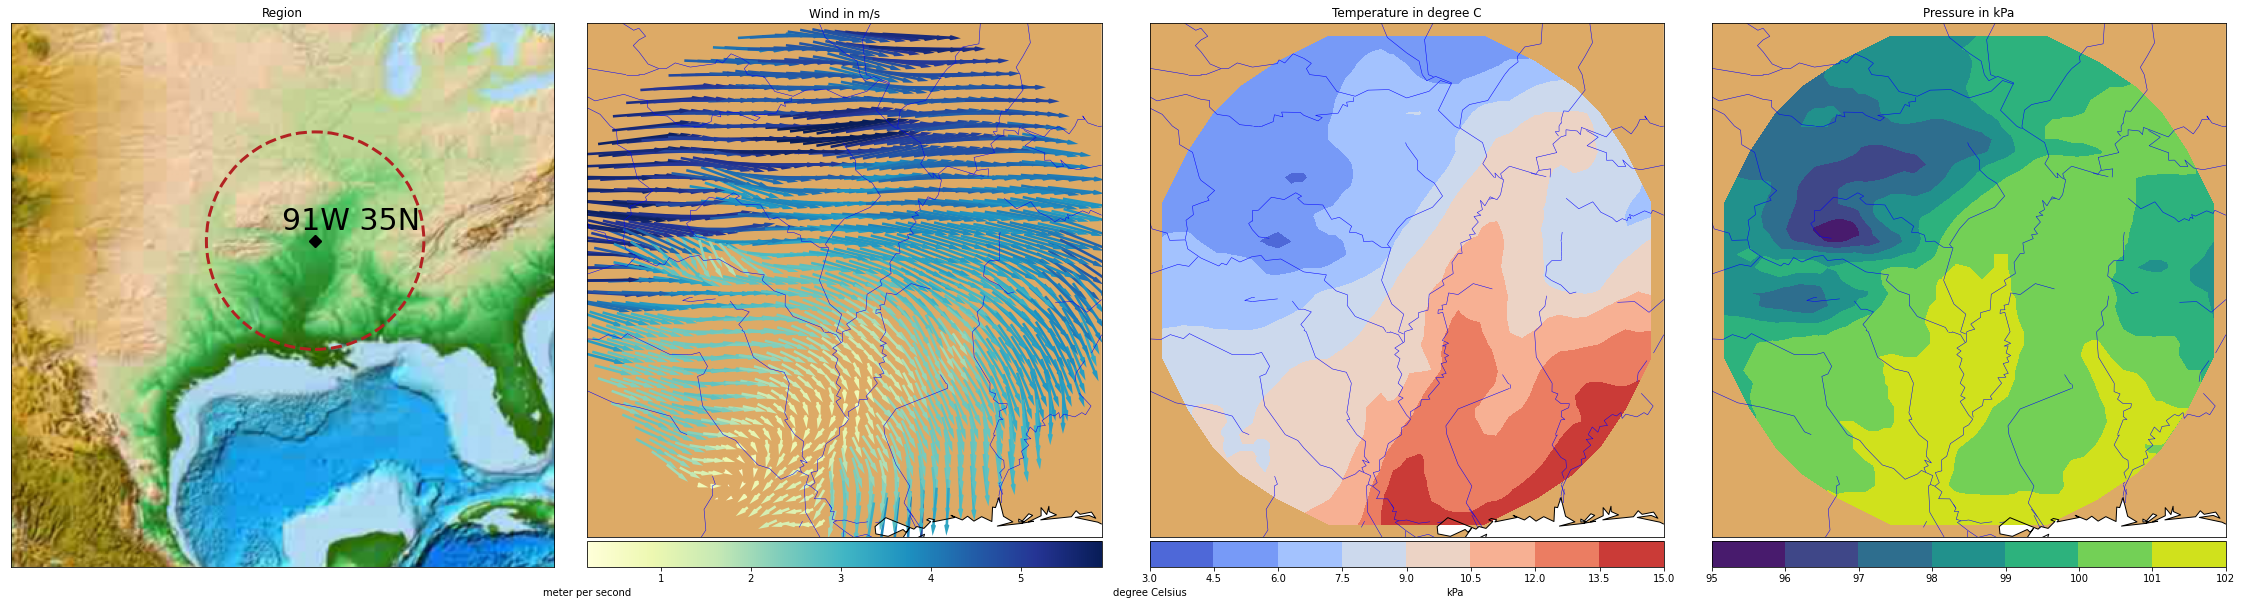

In [21]:
fig, ax=plt.subplots(nrows=1,ncols=4,figsize=(4*10,10))
scale=6.
width=2
m_2 = Basemap(llcrnrlon=-105,llcrnrlat=20,urcrnrlon=-80,urcrnrlat=45, resolution=None,ax=ax[0])
m_2.etopo()
circle=Circle((-91.,35), 5, fill=False,linewidth=3,edgecolor='firebrick',linestyle='--')
ax[0].scatter([-91],[35],color='black', marker='x',linewidth=10)
ax[0].annotate("91W 35N", xy=(-91,35),xytext=(-92.5,35.5),fontsize=30,color='black')
ax[0].add_patch(circle)

#ax[0].set_title('Region')
X,Y=test_dataset.get_rand_map()
for j in range(1,4):
    m = Basemap(llcrnrlon=-96.,llcrnrlat=30.,urcrnrlon=-86.,urcrnrlat=40., resolution='l',ax=ax[j])
    m.fillcontinents(color='#ddaa66',zorder=0)
    m.drawrivers(color='#0000ff')
    m.drawcoastlines()
        
#width=ax[0][i].get_xlim()[1]-ax[0][i].get_xlim()[0]
#ax[0][i].set_title("Wind")
wind_speed=Y[:,[2,3]].norm(dim=1)
norm = matplotlib.colors.Normalize()
norm.autoscale(wind_speed)
cm=plt.cm.YlGnBu

quiver=ax[1].quiver(X[:,0],X[:,1],Y[:,2],Y[:,3],wind_speed,pivot='mid',scale_units='width',scale=3*width*scale,headlength=4., headwidth = 2.,width=0.005,cmap=cm)
#ax[0].set_title("Wind | Sample "+str(i))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
cb=fig.colorbar(quiver, cax=cax,orientation='horizontal')
cb.set_label(label="meter per second",x=0.)

tricontour=ax[2].tricontourf(X[:,0],X[:,1],Y[:,1],cmap=plt.cm.coolwarm)
divider1 = make_axes_locatable(ax[2])
cax1 = divider1.append_axes("bottom", size="5%", pad=0.05)
cb1=fig.colorbar(tricontour, cax=cax1,orientation='horizontal')
cb1.set_label(label="",x=0.)

ax[3].set_title("Temperature | Sample "+str(j))
tricontour2=ax[3].tricontourf(X[:,0],X[:,1],Y[:,0])
divider2 = make_axes_locatable(ax[3])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.05)
cb2=fig.colorbar(tricontour2, cax=cax2,orientation='horizontal')
cb2.set_label(label="",x=-0.5)

plt.subplots_adjust(wspace=0.03, hspace=0.)
plt.savefig("ERA5_US_Illustration.pdf",pad_inches=0.,bbox_inches='tight')
ax[0].set_title("Region")
ax[1].set_title("Wind in m/s")
ax[2].set_title("Temperature in degree C")
ax[3].set_title("Pressure in kPa")




In [6]:
train_dict=torch.load('../../Experiments/ERA5/Saved_Models/D4_ERA5_US_big_2_2020_09_08_08_48',map_location=torch.device('cpu'))
CNP=EquivCNP.EquivCNP.create_model_from_dict(train_dict['CNP_dict'])

FileNotFoundError: [Errno 2] No such file or directory: '../../Experiments/ERA5/Saved_Models/D4_ERA5_US_big_2_2020_09_08_08_48'

In [51]:
def plot_Covs(ax,X_Target,Cov_Mat,scale=20,x1_lim=[-10,10],x2_lim=[-10,10],alpha=1.,facecolor='orange',edgecolor='grey'):
    '''
    Inputs: ax - matplotlib.axes._subplots.AxesSubplot - axis to plot on
            X_Target - torch.Tensor - shape (n_t,2) - locations of the target set
            Cov_Mat - torch.Tensor - shape (n_t, 2 ,2) - covariance matrices 
            scale - float - scale for plotting quiver arrows
            x1_lim,x2_lim - [float,float] - range of x1- and x2-axis
            alpha - float - permeability of covariance ellipses
            facecolor - str - name of color to use to plot covariance ellipses
            edgecolor - str - name of the color to use to plot the edges of the covariance ellipses
    Output: Plots the covariance matrices as ellipses in R2 
    '''
    #Get the 66%-quantile for the chi-square distribution:
    chi_sq_quantile=math.sqrt(2.157)  #for 95%:5.99#

    if X_Target is not None and Cov_Mat is not None:
        #Set window:
        ax.set_xlim(x1_lim)
        ax.set_ylim(x2_lim)
        
        #Go over all target points and plot ellipse of continour lines of density of distributions:
        for j in range(X_Target.size(0)):
            #Get covarinace matrix:
            A=Cov_Mat[j]
            #Decompose A:
            eigen_decomp=torch.eig(A,eigenvectors=True)
            #Get the eigenvector corresponding corresponding to the largest eigenvalue:
            u=eigen_decomp[1][:,0]

            #Get the angle of the ellipse in degrees:
            angle=360*torch.atan(u[1]/u[0])/(2*math.pi)
        
            #Get the width and height of the ellipses (eigenvalues of A):
            D=eigen_decomp[0][:,0]
            width=2*chi_sq_quantile*torch.sqrt(D[0])/scale
            height=2*chi_sq_quantile*torch.sqrt(D[1])/scale
            #Plot the Ellipse:
            E=Ellipse(xy=X_Target[j,].numpy(),width=width,height=height,angle=angle,alpha=alpha,zorder=0,facecolor=facecolor,edgecolor=edgecolor,linewidth=1.)
            #E.set_color(colormap(traces[j].item()))
            #E.set_facecolor(colormap(traces[j].item()))
            ax.add_patch(E)
    return(ax)

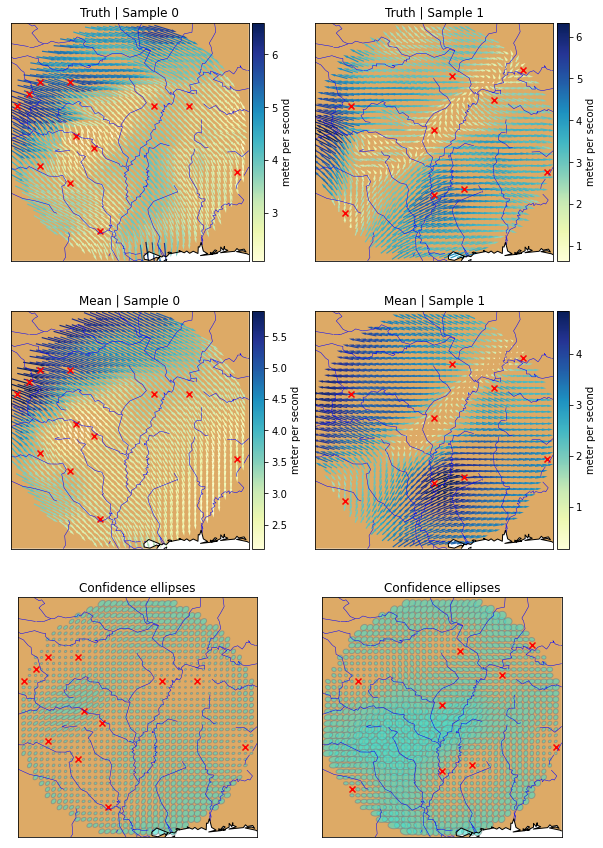

In [66]:
fig, ax=plt.subplots(nrows=3,ncols=2,figsize=(10,15))
scale=6.
width=10
for i in range(2):
    X,Y=test_dataset.get_rand_map()
    for j in range(3):
        pass
        m = Basemap(llcrnrlon=-96.,llcrnrlat=30.,urcrnrlon=-86.,urcrnrlat=40., resolution='l',ax=ax[j][i])
        m.fillcontinents(color='#ddaa66',zorder=0)
        m.drawrivers(color='#0000ff')
        m.drawcoastlines()
    batch_X_Context,batch_Y_Context,batch_X_Target,batch_Y_Target=test_dataset.get_rand_batch(batch_size=1,cont_in_target=False)
    X_Context=batch_X_Context.squeeze()
    Y_Context=batch_Y_Context.squeeze()
    X_Target=batch_X_Target.squeeze()
    Y_Target=batch_Y_Target.squeeze()
    Predict,Sigmas=CNP(batch_X_Context,batch_Y_Context,batch_X_Target)
    

    X=test_dataset.translater.denorm_X(X_Target)
    X_c=test_dataset.translater.denorm_X(X_Context)
    Y=test_dataset.translater.denorm_Y_out(Y_Target)
    Predict_denorm=test_dataset.translater.denorm_Y_out(Predict).squeeze().detach()
    wind_speed=Y.norm(dim=1).detach()
    quiver=ax[0][i].quiver(X[:,0],X[:,1],Y[:,0],Y[:,1],wind_speed,pivot='mid',scale_units='width',scale=width*scale,headlength=4., headwidth = 2.,width=0.005,cmap=cm)
    ax[0][i].set_title("Truth | Sample "+str(i))
    divider = make_axes_locatable(ax[0][i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb=fig.colorbar(quiver, cax=cax)
    cb.set_label(label="meter per second",x=0.)
    
    wind_speed=Predict_denorm.norm(dim=1)
    quiver=ax[1][i].quiver(X[:,0],X[:,1],Predict_denorm[:,0],Predict_denorm[:,1],wind_speed,pivot='mid',scale_units='width',scale=width*scale,headlength=4., headwidth = 2.,width=0.005,cmap=cm)
    ax[1][i].set_title("Mean | Sample "+str(i))
    divider = make_axes_locatable(ax[1][i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb=fig.colorbar(quiver, cax=cax)
    cb.set_label(label="meter per second",x=0.)

    plot_Covs(ax[2][i],X,Sigmas[0].detach(),scale=3,x1_lim=[-96,-86],x2_lim=[30,40],alpha=0.6,facecolor='turquoise',edgecolor='grey')
    ax[2][i].set_title("Confidence ellipses")

    ax[0][i].scatter(X_c[:,0],X_c[:,1],color='red',marker='x')
    ax[1][i].scatter(X_c[:,0],X_c[:,1],color='red',marker='x')
    ax[2][i].scatter(X_c[:,0],X_c[:,1],color='red',marker='x')

plt.savefig("ERA5_Predictions_4.png",pad_inches=0.,bbox_inches='tight')
